In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [5]:
from TSFEA import *

In [6]:
tsfea = TSFEA()

# Get Earnings Number to Homogenize Dates across Tickers

In [45]:
homogenized_earnings = tsfea.homogenize_earnings_dates('AllEarningsFmt.csv')
homogenized_earnings.head()

CUSIP       EDATE        LFRI  PrePRC  OpmPRC  PostPRC  \
TICKER ANNDATS                                                               
000R   20191106  14163310  2019-11-06  2019-11-01   11.96   12.02    12.35   
       20190806  14163310  2019-08-06  2019-08-02   10.22   10.71     7.73   
       20190509  14163310  2019-05-09  2019-05-03   16.32   16.40    14.94   
       20190307  14163310  2019-03-07  2019-03-01   24.17   25.54    22.80   
       20181108  14163310  2018-11-08  2018-11-02   18.00   18.10    18.85   

                 ERNUM  
TICKER ANNDATS          
000R   20191106     15  
       20190806     14  
       20190509     13  
       20190307     12  
       20181108     11

# Reconcile Estimates Dates

In [26]:
reconciled_estimates = tsfea.reconcile_estimates_with_earnings(
    'InitialEstimatesData20182022.csv',
    homogenized_earnings
)

In [21]:
reconciled_estimates.head()

OFTIC     CUSIP          CNAME  STATPERS MEASURE FISCALP  FPI  \
TICKER ERNUM                                                                 
00AI   1      WATT  29272C10  ENERGOUS CORP  20210520     EPS     QTR    6   
       1      WATT  29272C10  ENERGOUS CORP  20210617     EPS     QTR    6   
       1      WATT  29272C10  ENERGOUS CORP  20210715     EPS     QTR    6   
       1      WATT  29272C10  ENERGOUS CORP  20210318     EPS     QTR    7   
       1      WATT  29272C10  ENERGOUS CORP  20210415     EPS     QTR    7   

             ESTFLAG  NUMEST  NUMUP  NUMDOWN  MEDEST  MEANEST  STDEV  HIGHEST  \
TICKER ERNUM                                                                    
00AI   1           P       2      1        1   -0.12    -0.12   0.01    -0.11   
       1           P       2      0        0   -0.12    -0.12   0.01    -0.11   
       1           P       2      0        0   -0.12    -0.12   0.01    -0.11   
       1           P       2      1        0   -0.12    -0.12   0.00    -0.12   
       1           P       2      0        0   -0.12    -0.12   0.00    -0.12   

              LOWEST  
TICKER ERNUM          
00AI   1       -0.13  
       1       -0.13  
       1       -0.13  
       1       -0.12  
       1       -0.12

In [226]:
reconciled_estimates.loc["AAPL"]

,OFTIC,CUSIP,CNAME,STATPERS,MEASURE,FISCALP,FPI,ESTFLAG,NUMEST,NUMUP,NUMDOWN,MEDEST,MEANEST,STDEV,HIGHEST,LOWEST
ERNUM,,,,,,,,,,,,,,,,
0,AAPL,03783310,APPLE INC,20210520,EPS,QTR,6,P,28,26,1,0.99,1.00,0.07,1.16,0.82
0,AAPL,03783310,APPLE INC,20210617,EPS,QTR,6,P,28,0,1,0.99,0.99,0.07,1.16,0.82
0,AAPL,03783310,APPLE INC,20210715,EPS,QTR,6,P,28,4,1,1.00,1.00,0.07,1.16,0.82
0,AAPL,03783310,APPLE INC,20210218,EPS,QTR,7,P,28,22,3,0.82,0.82,0.06,0.98,0.70
0,AAPL,03783310,APPLE INC,20210318,EPS,QTR,7,P,28,0,1,0.82,0.82,0.06,0.98,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,AAPL,03783310,APPLE INC,20200917,EPS,QTR,8,P,24,2,6,0.83,0.84,0.12,1.12,0.57
15,AAPL,03783310,APPLE INC,20201015,EPS,QTR,8,P,25,3,5,0.81,0.83,0.11,1.12,0.57
15,AAPL,03783310,APPLE INC,20200514,EPS,QTR,9,P,22,8,10,3.20,3.23,0.34,3.99,2.59


# Reconcile Returns

In [110]:
reconciled_returns = tsfea.reconcile_returns_with_earnings(
    'dsf_save3.csv',
    homogenized_earnings
)

In [111]:
reconciled_returns.head()

CUSIP  PERMNO    PRC   returns
TICKER ERNUM                                   
000R   0      14163310   14378  11.89 -0.037247
       0      14163310   14378  11.96  0.005887
       0      14163310   14378  11.83 -0.010870
       0      14163310   14378  11.87  0.003381
       0      14163310   14378  11.97  0.008425

# Feature Extraction

In [112]:
medest_features = tsfea.extract_features_from_column(
    reconciled_estimates,
    'MEDEST'
)

In [113]:
medest_features.head()

MEDESTDN_HistogramMode_5  MEDESTDN_HistogramMode_10  \
TICKER ERNUM                                                        
00AI   0                  3.980689e-01               9.056067e-01   
       2                           NaN                        NaN   
       3                 -8.881784e-16              -8.881784e-16   
       4                  8.490331e-01               9.515026e-01   
       5                 -5.250000e-01              -6.375000e-01   

              MEDESTCO_f1ecac  MEDESTCO_FirstMin_ac  \
TICKER ERNUM                                          
00AI   0             2.590830                   7.0   
       2             0.000000                   0.0   
       3             0.505696                   2.0   
       4             0.677410                   2.0   
       5             1.704643                   6.0   

              MEDESTCO_HistogramAMI_even_2_5  MEDESTCO_trev_1_num  \
TICKER ERNUM                                                        
00AI   0                            0.547993             0.188513   
       2                                 NaN                  NaN   
       3                            0.693147             0.000000   
       4                            0.500402            -1.423097   
       5                            0.389048             1.265625   

              MEDESTMD_hrv_classic_pnn40  \
TICKER ERNUM                               
00AI   0                        0.214286   
       2                             NaN   
       3                        0.666667   
       4                        0.666667   
       5                        0.333333   

              MEDESTSB_BinaryStats_mean_longstretch1  \
TICKER ERNUM                                           
00AI   0                                        24.0   
       2                                         NaN   
       3                                         2.0   
       4                                         2.0   
       5                                         3.0   

              MEDESTSB_TransitionMatrix_3ac_sumdiagcov  \
TICKER ERNUM                                             
00AI   0                                      0.027778   
       2                                           NaN   
       3                                      0.074074   
       4                                      0.074074   
       5                                      0.166667   

              MEDESTPD_PeriodicityWang_th0_01  ...  \
TICKER ERNUM                                   ...   
00AI   0                                 14.0  ...   
       2                                  0.0  ...   
       3                                  0.0  ...   
       4                                  0.0  ...   
       5                                  2.0  ...   

              MEDESTFC_LocalSimple_mean1_tauresrat  \
TICKER ERNUM                                         
00AI   0                                  0.142857   
       2                                       NaN   
       3                                  1.000000   
       4                                  1.000000   
       5                                  0.250000   

              MEDESTDN_OutlierInclude_p_001_mdrmd  \
TICKER ERNUM                                        
00AI   0                                 0.635294   
       2                                      NaN   
       3                                 0.250000   
       4                                 0.428571   
       5                                 0.700000   

              MEDESTDN_OutlierInclude_n_001_mdrmd  \
TICKER ERNUM                                        
00AI   0                                -0.270588   
       2                                      NaN   
       3                                 0.250000   
       4                                 0.000000   
       5                                -0.300000   

              MEDESTSP_Summaries_welch_rect_area_

In [227]:
medest_features.loc['AAPL']

,MEDESTDN_HistogramMode_5,MEDESTDN_HistogramMode_10,MEDESTCO_f1ecac,MEDESTCO_FirstMin_ac,MEDESTCO_HistogramAMI_even_2_5,MEDESTCO_trev_1_num,MEDESTMD_hrv_classic_pnn40,MEDESTSB_BinaryStats_mean_longstretch1,MEDESTSB_TransitionMatrix_3ac_sumdiagcov,MEDESTPD_PeriodicityWang_th0_01,...,MEDESTFC_LocalSimple_mean1_tauresrat,MEDESTDN_OutlierInclude_p_001_mdrmd,MEDESTDN_OutlierInclude_n_001_mdrmd,MEDESTSP_Summaries_welch_rect_area_5_1,MEDESTSB_BinaryStats_diff_longstretch0,MEDESTSB_MotifThree_quantile_hh,MEDESTSC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,MEDESTSC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,MEDESTSP_Summaries_welch_rect_centroid,MEDESTFC_LocalSimple_mean3_stderr
ERNUM,,,,,,,,,,,,,,,,,,,,,
0,0.110586,-0.154897,4.311383,9.0,0.523867,0.119498,0.352941,16.0,0.020576,0.0,...,0.111111,0.674419,-0.755814,6.541446e-01,4.0,1.590129,0.515152,0.636364,0.294524,0.821534
2,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.589359,-0.021302,0.502655,1.0,0.000000,3.883793,1.000000,1.0,0.111111,0.0,...,1.000000,1.000000,0.000000,0.000000e+00,2.0,1.098612,0.000000,0.000000,1.570796,NaN
4,-0.483795,-0.325049,0.773574,2.0,1.332179,-0.888972,0.833333,4.0,0.111111,0.0,...,0.500000,0.285714,0.142857,1.375664e-35,3.0,1.560710,0.000000,0.000000,1.570796,1.766038
5,-0.430636,-0.263765,0.956340,3.0,0.562335,-1.141338,0.666667,3.0,0.074074,0.0,...,0.333333,-0.600000,0.200000,2.773339e-33,3.0,1.735126,0.000000,0.000000,1.178097,0.905697
6,-0.051138,0.148031,0.645500,3.0,0.186454,2.693161,0.909091,7.0,0.066667,0.0,...,0.500000,-0.166667,-0.583333,1.027163e-33,3.0,1.846220,0.000000,0.000000,1.570796,1.050979
7,0.671692,0.671692,1.361591,6.0,0.370486,1.168119,0.545455,5.0,0.166667,2.0,...,0.200000,0.416667,-0.666667,2.567907e-34,3.0,1.767761,0.000000,0.000000,0.392699,0.901875
8,-0.765285,-0.882421,1.742698,6.0,0.534382,0.774478,1.000000,3.0,0.166667,2.0,...,0.200000,0.666667,-0.416667,7.767917e-33,3.0,2.019815,0.000000,0.000000,0.392699,0.712251
9,-0.625408,-0.472247,1.330317,5.0,0.516037,1.402865,0.727273,2.0,0.111111,0.0,...,0.333333,0.750000,0.000000,2.311116e-33,3.0,1.414279,0.000000,0.000000,0.785398,1.153591


In [114]:
return_features = tsfea.extract_features_from_column(
    reconciled_returns,
    'returns'
)

In [115]:
return_features.head()

returnsDN_HistogramMode_5  returnsDN_HistogramMode_10  \
TICKER ERNUM                                                          
000R   0                       0.601841                    0.178407   
       8                       0.624526                    0.076035   
       9                       0.404421                    0.009646   
       10                      0.185965                    0.185965   
       11                     -0.593572                   -0.199666   

              returnsCO_f1ecac  returnsCO_FirstMin_ac  \
TICKER ERNUM                                            
000R   0              0.584964                    1.0   
       8              0.594238                    1.0   
       9              0.681546                    2.0   
       10             0.752280                    3.0   
       11             0.663511                    2.0   

              returnsCO_HistogramAMI_even_2_5  returnsCO_trev_1_num  \
TICKER ERNUM                                                          
000R   0                             0.071439             -0.918074   
       8                             0.101418             -1.002263   
       9                             0.014830              3.319158   
       10                            0.036644             -0.712857   
       11                            0.039674              1.243307   

              returnsMD_hrv_classic_pnn40  \
TICKER ERNUM                                
000R   0                         0.825397   
       8                         0.982759   
       9                         0.937500   
       10                        0.964286   
       11                        0.971831   

              returnsSB_BinaryStats_mean_longstretch1  \
TICKER ERNUM                                            
000R   0                                          4.0   
       8                                          9.0   
       9                                          3.0   
       10                                         6.0   
       11                                         5.0   

              returnsSB_TransitionMatrix_3ac_sumdiagcov  \
TICKER ERNUM                                              
000R   0                                       0.011758   
       8                                       0.001090   
       9                                       0.020576   
       10                                      0.005144   
       11                                      0.019048   

              returnsPD_PeriodicityWang_th0_01  ...  \
TICKER ERNUM                                    ...   
000R   0                                   6.0  ...   
       8                                   8.0  ...   
       9                                   2.0  ...   
       10                                 10.0  ...   
       11                                  2.0  ...   

              returnsFC_LocalSimple_mean1_tauresrat  \
TICKER ERNUM                                          
000R   0                                   1.000000   
       8                                   1.000000   
       9                                   0.200000   
       10                                  0.333333   
       11                                  0.500000   

              returnsDN_OutlierInclude_p_001_mdrmd  \
TICKER ERNUM                                         
000R   0                                 -0.250000   
       8                                  0.050847   
       9                                 -0.224490   
       10                                -0.350877   
       11                                 0.500000   

              returnsDN_OutlierInclude_n_001_mdrmd  \
TICKER ERNUM                                         
000R   0                                 -0.562500   
       8                                  0.220339   
       9                                 -0.163265   
       10                                 0.438596   
       11    

# Prediction Test

### Add Models

In [131]:
tsfea.models = {
    'XGBClf': XGBClassifier(eval_metric='error')
}

tsfea.hyparam_space = {
    'XGBClf': {
        'max_depth': scope.int(hp.quniform("max_depth", 3, 18, 1)),
        'gamma': hp.uniform ('gamma', 0, 9),
        'reg_alpha' : hp.uniform('reg_alpha', 0, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : scope.int(hp.quniform('min_child_weight', 0, 10, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1))
    }
}

for more details on defining hyperparameter spaces, visit http://hyperopt.github.io/hyperopt/getting-started/search_spaces/, or google hyperparameter tuning [ml model] hyperopt.

In [180]:
target_earnings = homogenized_earnings.droplevel(
    1
).set_index(
    "ERNUM",
    append=True
).sort_index()

target_earnings["returns"] = (target_earnings.PostPRC / target_earnings.PrePRC - 1)
target_earnings["TARGET"] = pd.to_numeric(target_earnings.returns >= 0)

target_earnings = pd.DataFrame(
        target_earnings.loc[
        :,
        ["TARGET", "returns"]
    ]
)

In [181]:
df = target_earnings.join(
    return_features, 
    how='inner'
).join(
    medest_features,
    how='inner'
).groupby(
    level=[0, 1]
).fillna(
    method='ffill'
).fillna(
    0
)
df.head()

TARGET   returns  returnsDN_HistogramMode_5  \
TICKER ERNUM                                                
00AI   2       False -0.020138                  -0.853350   
       3        True  0.026599                   0.087686   
       4       False -0.088757                  -0.092983   
       5       False -0.085324                  -0.418384   
       6       False -0.238971                  -0.060193   

              returnsDN_HistogramMode_10  returnsCO_f1ecac  \
TICKER ERNUM                                                 
00AI   2                       -0.438334          0.699683   
       3                       -0.158264          0.559707   
       4                        0.123153          0.524531   
       5                       -0.166993          0.467555   
       6                       -0.493178          0.594393   

              returnsCO_FirstMin_ac  returnsCO_HistogramAMI_even_2_5  \
TICKER ERNUM                                                           
00AI   2                        2.0                         0.024380   
       3                        1.0                         0.098551   
       4                        1.0                         0.117062   
       5                        1.0                         0.139532   
       6                        1.0                         0.047507   

              returnsCO_trev_1_num  returnsMD_hrv_classic_pnn40  \
TICKER ERNUM                                                      
00AI   2                  2.631426                     0.823529   
       3                  0.403508                     0.980000   
       4                 -0.210589                     1.000000   
       5                  3.508980                     0.983871   
       6                 -2.801294                     0.974684   

              returnsSB_BinaryStats_mean_longstretch1  ...  \
TICKER ERNUM                                           ...   
00AI   2                                          3.0  ...   
       3                                          6.0  ...   
       4                                          4.0  ...   
       5                                          6.0  ...   
       6                                          8.0  ...   

              MEDESTFC_LocalSimple_mean1_tauresrat  \
TICKER ERNUM                                         
00AI   2                                      0.00   
       3                                      1.00   
       4                                      1.00   
       5                                      0.25   
       6                                      0.20   

              MEDESTDN_OutlierInclude_p_001_mdrmd  \
TICKER ERNUM                                        
00AI   2                                 0.000000   
       3                                 0.250000   
       4                                 0.428571   
       5                                 0.700000   
       6                                 0.846154   

              MEDESTDN_OutlierInclude_n_001_mdrmd  \
TICKER ERNUM                                        
00AI   2                                 0.000000   
       3                                 0.250000   
       4                                 0.000000   
       5                                -0.300000   
       6                                -0.384615   

              MEDESTSP_Summaries_welch_rect_area_5_1  \
TICKER ERNUM                                           
00AI   2                                0.000000e+00   
       3                                0.000000e+00   
       4                                8.804251e-34   
       5                                2.773339e-33   
       6                                9.481501e-34   

              MEDESTSB_BinaryStats_diff_longstretch0  \
TICKER ERNUM                                           
00AI   2                                         0.0   
       3                                         1.0   
 

In [221]:
i, j = 0, 5
ret = []
while j < df.index.get_level_values(1).max():
    (
        X_train, 
        X_test, 
        y_train, 
        y_test
    ) = (
        df.loc[(slice(None), slice(i, j)), :].drop(columns=["TARGET", "returns"]),
        df.loc[(slice(None), j+1), :].drop(columns=["TARGET", "returns"]),
        df.loc[(slice(None), slice(i, j)), "TARGET"],
        df.loc[(slice(None), j+1), "TARGET"],
    )

    y_pred = tsfea.tune_train_predict(
        X_train,
        X_test,
        y_train,
        y_test,
        'XGBClf',
        5,
        20
    )

    temp = pd.Series(y_pred, index=y_test.index).replace(0, -1).mul(df.loc[(slice(None), j+1), "returns"]).groupby(level=1).sum()
    print(temp)
    ret.append(temp)

    i += 1
    j += 1

100%|██████████| 20/20 [00:17<00:00,  1.11trial/s, best loss: -0.6142843040178388]
ERNUM
6    14.140653
dtype: float64
100%|██████████| 20/20 [00:13<00:00,  1.44trial/s, best loss: -0.6733104557732332]
ERNUM
7   -1.971096
dtype: float64
100%|██████████| 20/20 [00:24<00:00,  1.23s/trial, best loss: -0.6019851262136001]
ERNUM
8    18.545172
dtype: float64
100%|██████████| 20/20 [00:24<00:00,  1.22s/trial, best loss: -0.6021982924509791]
ERNUM
9    18.438204
dtype: float64
100%|██████████| 20/20 [00:22<00:00,  1.15s/trial, best loss: -0.6172999338576619]
ERNUM
10    20.4938
dtype: float64
100%|██████████| 20/20 [00:24<00:00,  1.22s/trial, best loss: -0.6052374675364294]
ERNUM
11    11.249051
dtype: float64
100%|██████████| 20/20 [00:23<00:00,  1.17s/trial, best loss: -0.5835749470501338]
ERNUM
12    9.630617
dtype: float64
100%|██████████| 20/20 [00:31<00:00,  1.59s/trial, best loss: -0.5967721383374373]
ERNUM
13    9.206557
dtype: float64
100%|██████████| 20/20 [00:26<00:00,  1.34s/trial

In [222]:
all_ret_rolling = pd.concat(ret)
all_ret_rolling.describe()

count     10.000000
mean      34.409345
std       69.005633
min       -1.971096
25%       10.035225
50%       14.276058
75%       18.518430
max      229.949029
dtype: float64

<AxesSubplot:xlabel='ERNUM'>

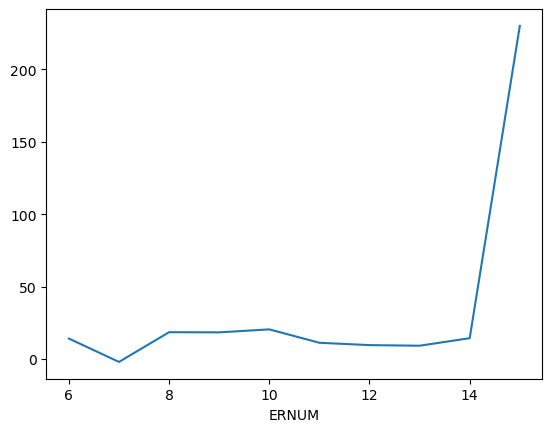

In [224]:
all_ret_rolling.plot()

In [220]:
all_ret_expanding = pd.concat(ret[:-1])
all_ret_expanding.describe()

count     9.000000
mean     12.421464
std       6.341905
min       2.273591
25%       7.583650
50%      12.252715
75%      17.723793
max      20.542314
dtype: float64

<AxesSubplot:xlabel='ERNUM'>

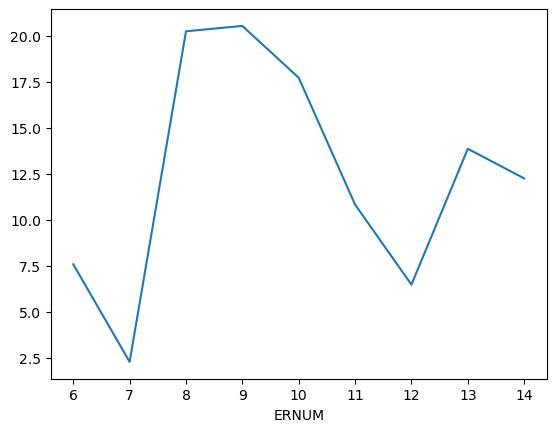

In [225]:
all_ret_expanding.plot()

# Toy Prediction Test

In [94]:
from sklearn.datasets import load_breast_cancer

In [95]:
data = load_breast_cancer()
X, y = data.data, data.target

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [151]:
y_pred = tsfea.tune_train_predict(
    X_train,
    X_test,
    y_train,
    y_test,
    'XGBClf',
    15,
    50
)

100%|██████████| 50/50 [00:35<00:00,  1.41trial/s, best loss: -0.9479826194909994]
